In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

### Download Turnstile Data by Datecode

In [2]:
# Creates dataframe from CSVs on MTA site based on URL-ending datecodes
def get_data(datecodes):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for datecode in datecodes:
        file_url = url.format(datecode)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
# Enter datecodes in YYMMDD format
datecodes = [170603, 170527, 160604, 160528, 150606, 150530]

turnstiles_df = get_data(datecodes)

In [3]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,00:00:00,REGULAR,6195217,2098317
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,04:00:00,REGULAR,6195240,2098318
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,08:00:00,REGULAR,6195256,2098347
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,12:00:00,REGULAR,6195346,2098432
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,16:00:00,REGULAR,6195518,2098491


### Download Station Coordinates and Filter by Map Area

In order to target tech employees during their commute, we want to focus on the subway stops from 14th to 42nd Streets where many NYC tech firms have their offices.

In [4]:
stations = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

stations = stations[['Stop Name','Daytime Routes','GTFS Latitude', 'GTFS Longitude']]
stations.columns = ['STATION','LINENAME','LAT', 'LONG']
stations = stations[(stations.LAT >= 40.731191) & (stations.LAT <= 40.753512) &
                      (stations.LONG >= -74.001387) & (stations.LONG <= -73.977641)]

In [5]:
clean_stations = []
for station in stations.STATION:
    clean = station.upper() \
                     .replace(' - ','-') \
                     .replace('STATION', 'STA') \
                     .replace('GRAND CENTRAL-42 ST', 'GRD CNTRL-42 ST')
                
    clean_stations.append(clean)
    
clean_linenames = []
for linename in stations.LINENAME:
    clean = linename.replace(' ','')
    clean_linenames.append(clean)

stations.STATION = clean_stations
stations.LINENAME = clean_linenames

In [6]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,00:00:00,REGULAR,6195217,2098317
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,04:00:00,REGULAR,6195240,2098318
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,08:00:00,REGULAR,6195256,2098347
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,12:00:00,REGULAR,6195346,2098432
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,16:00:00,REGULAR,6195518,2098491


In [7]:
df = pd.merge(turnstiles_df,stations,on='STATION')

In [8]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME_x,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,LINENAME_y,LAT,LONG
0,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2017,00:00:00,REGULAR,23493363,9354682,NQRW,40.749567,-73.987950
1,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2017,00:00:00,REGULAR,23493363,9354682,BDFM,40.749719,-73.987823
2,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2017,04:00:00,REGULAR,23493633,9354720,NQRW,40.749567,-73.987950
3,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2017,04:00:00,REGULAR,23493633,9354720,BDFM,40.749719,-73.987823
4,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2017,08:00:00,REGULAR,23493686,9354798,NQRW,40.749567,-73.987950


In [9]:
# strip out whitespace
df.columns = [column.strip() for column in df.columns]
df.LINENAME_y = df.LINENAME_y.str.strip()
df.LINENAME_x = df.LINENAME_x.str.strip()

In [10]:
df.shape

(236645, 14)

There are multiple stations with the same name (e.g. 14th Street) but different lines. We need to filter out rows where LINENAME from the **Station Coordinate** table (LINENAME_y) is not in the LINENAME from the **Turnstile Table** (LINENAME_x). 

In [11]:
df = df[df.apply(lambda row: row.LINENAME_y in row.LINENAME_x, axis=1)]

In [12]:
df.shape

(107765, 14)

In [13]:
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")

df = df.sort_values("DATE_TIME", ascending = True)

In [14]:
df['DAYOFWEEK'] = df['DATE_TIME'].dt.dayofweek

maxdf = df.sort_values(by=['DATE_TIME']).groupby(['C/A', 'UNIT', 'SCP', 'STATION', 
                                                  'DATE_TIME', 'DATE', 'TIME', 'DAYOFWEEK'], 
                                                 as_index = False).ENTRIES.max()

entrydf = maxdf.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'], as_index = False).ENTRIES.max()

entrydf['DAILY'] = maxdf.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'], 
                                 as_index = False).ENTRIES.max()['ENTRIES'] - \
                   maxdf.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'], 
                                 as_index = False).ENTRIES.min()['ENTRIES']

entrydf = entrydf.drop(['ENTRIES'], axis = 1)

In [15]:
df = pd.merge(maxdf, entrydf, on=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])
dfshift = df.shift(1)

In [16]:
df['PREVDT'] = dfshift['DATE_TIME']
df['PREVENT'] = dfshift['ENTRIES']
df['PREVTIME'] = dfshift['TIME']
df['ENTRIESDIFF'] = df['ENTRIES'] - df['PREVENT']
df['TIMEDIFF'] = df['DATE_TIME'] - df['PREVDT']
df['ENTRYPROP'] = df['ENTRIESDIFF']/df['DAILY']

In [17]:
df = df.sort_values('ENTRIESDIFF')
df.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,DAYOFWEEK,ENTRIES,DAILY,PREVDT,PREVENT,PREVTIME,ENTRIESDIFF,TIMEDIFF,ENTRYPROP
71267,R226,R131,02-03-00,23 ST,2015-05-23 01:00:00,05/23/2015,01:00:00,5,9466120,236,2017-06-02 21:00:00,1.997627e+09,21:00:00,-1.988161e+09,-742 days +04:00:00,-8.424412e+06
15652,N067,R012,00-03-00,34 ST-PENN STA,2016-05-21 00:00:00,05/21/2016,00:00:00,5,2465338,843,2015-06-05 20:00:00,1.963519e+09,20:00:00,-1.961053e+09,350 days 04:00:00,-2.326279e+06
93524,R238A,R046,02-00-03,GRD CNTRL-42 ST,2016-05-23 16:00:00,05/23/2016,16:00:00,0,268435956,1609770862,2016-05-23 12:00:00,1.878206e+09,12:00:00,-1.609770e+09,0 days 04:00:00,-9.999994e-01
62128,R138,R293,00-03-05,34 ST-PENN STA,2015-05-23 02:00:00,05/23/2015,02:00:00,5,1548735,1939,2017-06-02 22:00:00,1.568689e+09,22:00:00,-1.567140e+09,-742 days +04:00:00,-8.082208e+05
3045,A025,R023,01-06-00,34 ST-HERALD SQ,2015-05-23 00:00:00,05/23/2015,00:00:00,5,7889196,1014,2017-06-02 20:00:00,1.556007e+09,20:00:00,-1.548118e+09,-742 days +04:00:00,-1.526743e+06


In [18]:
# Filter out rows with incorrect/outlier time difference values
df = df[(df['TIMEDIFF'] >= '3 hours') & (df['TIMEDIFF'] <= '5 hours')]

df.shape

(94165, 16)

More than 99% of TIMEDIFF values are exactly 4 hours

In [19]:
# TIME DIFFERENCES
df.groupby('TIMEDIFF')['ENTRIES'].count().reset_index().sort_values('ENTRIES', ascending = False).head()

,TIMEDIFF,ENTRIES
54,04:00:00,93667
38,03:52:56,18
6,03:10:22,16
33,03:42:47,16
45,03:56:45,15


We can break up the day into six 4-hour time blocks as follows for analysis of the busiest periods for our targeted tech commuters.

In [20]:
# get the 6 4-hour blocks
df.loc[(df['PREVTIME'] >= '00:00:00') & (df['TIME'] <= '06:00:00'), 'TIMEBLOCK'] = 'block1'
df.loc[(df['PREVTIME'] >= '04:00:00') & (df['TIME'] <= '10:00:00'), 'TIMEBLOCK'] = 'block2'
df.loc[(df['PREVTIME'] >= '08:00:00') & (df['TIME'] <= '14:00:00'), 'TIMEBLOCK'] = 'block3'
df.loc[(df['PREVTIME'] >= '12:00:00') & (df['TIME'] <= '18:00:00'), 'TIMEBLOCK'] = 'block4'
df.loc[(df['PREVTIME'] >= '16:00:00') & (df['TIME'] <= '22:00:00'), 'TIMEBLOCK'] = 'block5'
df.loc[(df['PREVTIME'] >= '20:00:00') & (df['TIME'] <= '02:00:00'), 'TIMEBLOCK'] = 'block6'

In [21]:
# check that all time blocks are assigned
df[df['TIMEBLOCK'].isnull()]

,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,DAYOFWEEK,ENTRIES,DAILY,PREVDT,PREVENT,PREVTIME,ENTRIESDIFF,TIMEDIFF,ENTRYPROP,TIMEBLOCK


In [22]:
df = df.sort_values('ENTRIESDIFF', ascending = False)
df.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,DAYOFWEEK,ENTRIES,DAILY,PREVDT,PREVENT,PREVTIME,ENTRIESDIFF,TIMEDIFF,ENTRYPROP,TIMEBLOCK
11534,A037,R170,05-00-00,14 ST-UNION SQ,2017-05-25 17:00:00,05/25/2017,17:00:00,3,589824,588132,2017-05-25 13:00:00,1921.0,13:00:00,587903.0,04:00:00,0.999611,block4
92161,R238,R046,00-03-02,GRD CNTRL-42 ST,2017-05-22 20:00:00,05/22/2017,20:00:00,0,28718908,7718,2017-05-22 16:00:00,28714715.0,16:00:00,4193.0,04:00:00,0.543275,block5
92167,R238,R046,00-03-02,GRD CNTRL-42 ST,2017-05-23 20:00:00,05/23/2017,20:00:00,1,28729423,8658,2017-05-23 16:00:00,28725250.0,16:00:00,4173.0,04:00:00,0.481982,block5
92173,R238,R046,00-03-02,GRD CNTRL-42 ST,2017-05-24 20:00:00,05/24/2017,20:00:00,2,28740872,9764,2017-05-24 16:00:00,28736821.0,16:00:00,4051.0,04:00:00,0.414891,block5
92208,R238,R046,00-03-02,GRD CNTRL-42 ST,2017-05-30 20:00:00,05/30/2017,20:00:00,1,28777577,7804,2017-05-30 16:00:00,28773556.0,16:00:00,4021.0,04:00:00,0.515249,block5


In [23]:
# drop specific turnstiles with inaccurate ridership counts

dropkey = ((df["C/A"] == "A037") & 
           (df["UNIT"] == "R170") & 
           (df["SCP"] == "05-00-00") & 
           (df["STATION"] == "14 ST-UNION SQ") &
           (df["DATE"] == "05/25/2017"))

dropkey2 = ((df["C/A"] == "R238A") & 
            (df["UNIT"] == "R046") & 
            (df["SCP"] == "02-00-03") & 
            (df["STATION"] == "GRD CNTRL-42 ST") &
            (df["DATE"] == "05/23/2016"))

dropkey3 = ((df["C/A"] == "R241A") & 
            (df["UNIT"] == "R048") & 
            (df["SCP"] == "00-00-00") & 
            (df["STATION"] == "GRD CNTRL-42 ST") &
            ((df["DATE"] == "05/24/2017") ^ \
             (df["DATE"] == "05/23/2017") ^ \
             (df["DATE"] == "05/30/2017") ^ \
             (df["DATE"] == "05/22/2017") ^ \
             (df["DATE"] == "05/25/2017") ^ \
             (df["DATE"] == "05/31/2017")))

# collect indices and drop rows
droplist = df[dropkey].index.tolist()
droplist = droplist + df[dropkey2].index.tolist() + df[dropkey3].index.tolist()

df.drop(droplist,inplace=True)

df.shape

(94117, 17)

In [24]:
# remove weekends from dataset
df = df[(df['DAYOFWEEK'] != 5) & (df['DAYOFWEEK'] != 6)]

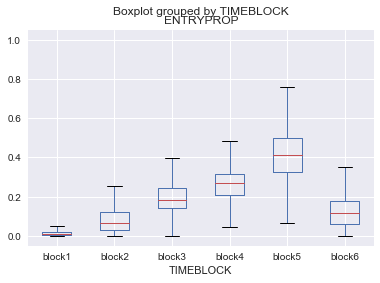

In [25]:
# box plot of time block entries as a percentage of total daily entries
bdf = df[(df['ENTRYPROP'] >= 0) & (df['ENTRYPROP'] <= 1)]

bdf.boxplot('ENTRYPROP', by='TIMEBLOCK');

In [26]:
df = df[(df['TIMEBLOCK'] == 'block4') ^ \
          (df['TIMEBLOCK'] == 'block5')] \
           .sort_values('ENTRIESDIFF', ascending = False)

# total ridership by time block, by station for last week of May and first week of June, 2015 to 2017
tbs = df.groupby(['TIMEBLOCK', 'STATION'], as_index = False).ENTRIESDIFF.sum()

tbs = tbs.sort_values('ENTRIESDIFF', ascending=False)

tbs['NAME'] = tbs['STATION'] + ' - ' + tbs['TIMEBLOCK']

In [27]:
# normalized
tbs.EntriesNorm = tbs.ENTRIESDIFF/(tbs.ENTRIESDIFF.sum())

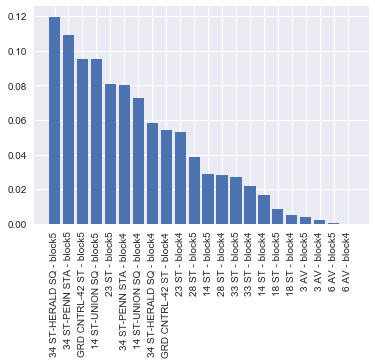

In [28]:
labels = [x for x in range(len(tbs.NAME))]
plt.bar(labels, tbs.EntriesNorm, align='center')
plt.xticks(labels, tbs.NAME, rotation='vertical')

plt.show()

In [29]:
# Overlapping time blocks account for non-standard turnstile timestamps
'''
0:00 to 6:00 = block1
4:00 to 10:00 = block2
8:00 to 14:00 = block3
12:00 to 18:00 = block4
16:00 to 22:00 = block5
20:00 to 2:00 = block6
'''

# Top two time blocks by ridership: block4 and block5
tbs.loc[tbs.TIMEBLOCK == 'block4', 'TIME_INTS'] = '12:00 PM - 6:00 PM'
tbs.loc[tbs.TIMEBLOCK == 'block5', 'TIME_INTS'] = '4:00 PM - 10:00 PM'

tbs.head()

,TIMEBLOCK,STATION,ENTRIESDIFF,NAME,TIME_INTS
18,block5,34 ST-HERALD SQ,1392337.0,34 ST-HERALD SQ - block5,4:00 PM - 10:00 PM
19,block5,34 ST-PENN STA,1268702.0,34 ST-PENN STA - block5,4:00 PM - 10:00 PM
21,block5,GRD CNTRL-42 ST,1111903.0,GRD CNTRL-42 ST - block5,4:00 PM - 10:00 PM
12,block5,14 ST-UNION SQ,1109225.0,14 ST-UNION SQ - block5,4:00 PM - 10:00 PM
14,block5,23 ST,941134.0,23 ST - block5,4:00 PM - 10:00 PM


### Final Chart for WomenTechWomenYes

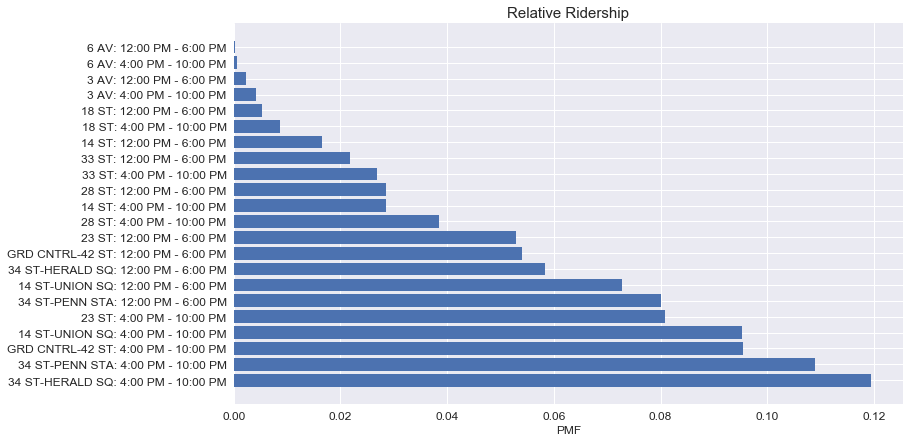

In [39]:
tbs.NAME = tbs.STATION + ': ' + tbs.TIME_INTS

plt.figure(figsize=(12,7))
plt.barh(labels, tbs.EntriesNorm, align='center')
plt.title("Relative Ridership",fontsize=15)

plt.yticks(labels, tbs.NAME,fontsize=12)
plt.xticks(fontsize=12)

plt.xlabel("PMF",fontsize=12)

plt.show()